In [1]:
import cv2
import os
import numpy as np
import json
import pandas as pd
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity
from matplotlib import colors
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/siamese-registration')

from datasets import RandomTransformationDataset
from models import *
from utils import get_transformation_matrix

In [4]:
path = "/content/drive/MyDrive/data"
outputs_path = "/content/drive/MyDrive/outputs"

In [5]:
test_dataset = RandomTransformationDataset(
    transforms=transforms.Compose([
        transforms.ToTensor(),
    ]),
    path=os.path.join(path, "test.pkl"),
    path_prefix="/content/drive/MyDrive"
)

test_loader = DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initial = fc
models = [
    {
        "folder": "02_resnet18_MSE",
        "checkpoint": "model-9.pt",
        "type": "concatenation"
    },
    {
        "folder": "16_sub_MSE_fc",
        "checkpoint": "checkpoint-20.pt",
        "type": "subtraction"
    },
    {
        "folder": "07_resnet18_MSE_corr_2",
        "checkpoint": "checkpoint-24.pt",
        "type": "correlation"
    },
]

m = models[2]
folder = m["folder"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = initial_siamese_resnet18(1, 7, m["type"])
if m["type"] == "concatenation":
    model.load_state_dict(torch.load(os.path.join(outputs_path, m["folder"], m["checkpoint"]), map_location=device))
else:
    model.load_state_dict(torch.load(os.path.join(outputs_path, m["folder"], m["checkpoint"]), map_location=device)['model_state_dict'])
model.cuda()
model.eval()
print(f"Running on {device}")

In [6]:
# Reg
models = [
    {
        "folder": "17_cat_MSE_reg",
        "checkpoint": "checkpoint-20.pt",
        "channels": [1024, 128, 64],
        "type": "concatenation"
    },
    {
        "folder": "15_sub_MSE_reg",
        "checkpoint": "checkpoint-19.pt",
        "channels": [512, 128, 64],
        "type": "subtraction"
    },
    {
        "folder": "11_resnet18_wMSE_corr_reg_4", # 11_resnet18_wMSE_corr_reg_4
        "checkpoint": "checkpoint-17.pt", # 17
        "channels": [384, 128, 64],
        "type": "correlation"
    },
]

m = models[2]
folder = m["folder"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = siamese_resnet18(1, 7, m["type"], m["channels"])
model.load_state_dict(torch.load(os.path.join(outputs_path, m["folder"], m["checkpoint"]), map_location=device)['model_state_dict'])
#model.cuda()
model.eval()
print(f"Running on {device}")

Running on cuda


In [7]:
def warp_from_params_and_eval(img0, img1, params):
    tx, ty, sx, sy, shx, shy, q = params
    rows, cols = img0.shape
    center = (cols//2, rows//2)
    matrix = get_transformation_matrix(center, tx, ty, sx, sy, shx, shy, q)
    matrix_opencv = np.float32(matrix.flatten()[:6].reshape(2, 3))
    inverse_matrix = cv2.invertAffineTransform(matrix_opencv)
    img1_warped = cv2.warpAffine(img1, inverse_matrix, (cols, rows))
    mask = (img1_warped != 0.0)
    mse = mean_squared_error(img0[mask], img1_warped[mask])
    ssim = structural_similarity(img0[mask], img1_warped[mask])
    return img1_warped, mse, ssim 

def warp_and_eval(img0, img1, method="sift"):
    rows, cols = img0.shape
    if method == "sift":
        detector = cv2.xfeatures2d.SIFT_create()
    elif method == "orb":
        detector = cv2.ORB_create(nfeatures=10000)
    else:
        raise NotImplemented()
    
    kp1, d1 = detector.detectAndCompute(img1, None)
    kp2, d2 = detector.detectAndCompute(img0, None)

    if (d1 is None) or (d2 is None):
        return img1, np.nan, np.nan

    matcher = cv2.BFMatcher(cv2.NORM_L1, crossCheck = True)
    matches = matcher.match(d1, d2)
    matches = sorted(matches, key = lambda x:x.distance)
    matches.sort(key = lambda x: x.distance)
    matches = matches[:int(len(matches)*0.9)]

    no_of_matches = len(matches)
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))
    for i in range(len(matches)):
      p1[i, :] = kp1[matches[i].queryIdx].pt
      p2[i, :] = kp2[matches[i].trainIdx].pt
    try:
        #homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
        homography, mask = cv2.estimateAffinePartial2D(p1, p2)
        img1_warped = cv2.warpAffine(img1, homography, (cols, rows))
        #print(f"{homography=}")
    except:
        return img1, np.nan, np.nan
    #img = cv2.drawMatches(img0, kp1, img0, kp2, matches[:100], img1, flags=2)
    #plt.imshow(img),plt.show()
    mask = (img1_warped != 0.0)
    mse = mean_squared_error(img0[mask], img1_warped[mask])
    ssim = structural_similarity(img0[mask], img1_warped[mask])
    return img1_warped, mse, ssim

In [8]:
loader = iter(test_loader)

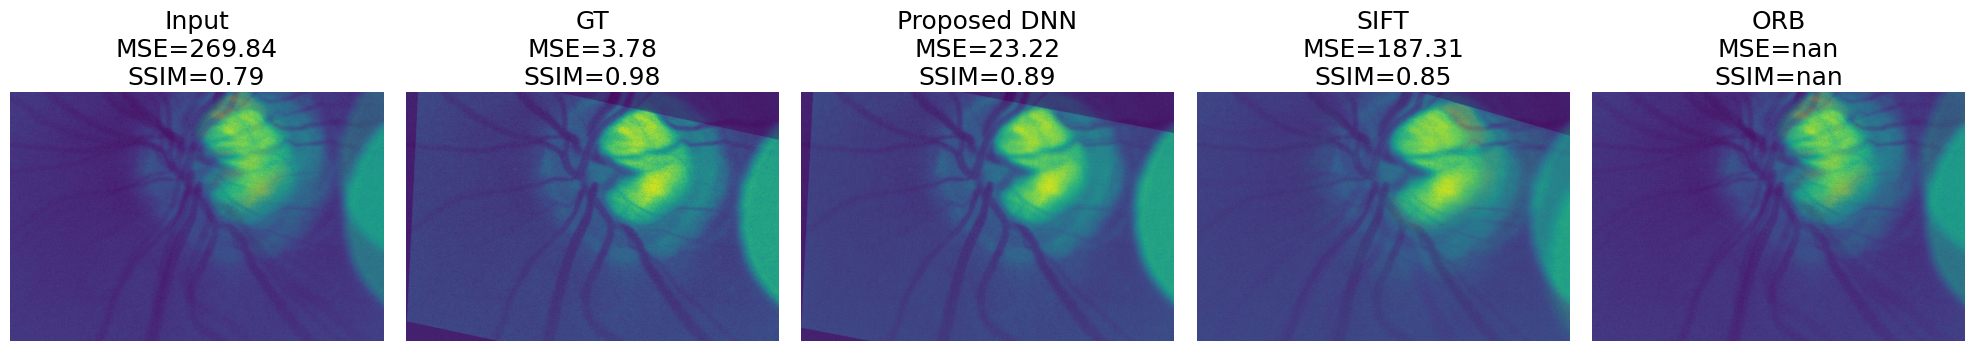

In [34]:
img0, img1, params0 = next(loader)

out = model(img0, img1)

params = params0.detach().cpu().numpy().reshape(-1).tolist()
outputs = out.detach().cpu().numpy().reshape(-1).tolist()

frame0 = img0.detach().cpu().numpy()[0, 0, :, :]
frame0 = (frame0 * 255).astype('uint8')
frame1 = img1.detach().cpu().numpy()[0, 0, :, :]
frame1 = (frame1 * 255).astype('uint8')


input_mse = mean_squared_error(frame0, frame1)
input_ssim = structural_similarity(frame0, frame1)
gt_im, gt_mse, gt_ssim = warp_from_params_and_eval(frame0, frame1, params)
net_im, net_mse, net_ssim = warp_from_params_and_eval(frame0, frame1, outputs)
orb_im, orb_mse, orb_ssim = warp_and_eval(frame0, frame1, method="orb")
sift_im, sift_mse, sift_ssim = warp_and_eval(frame0, frame1, method="sift")

plt.figure(figsize = (20,9))
plt.rc('font', size=15)

plt.subplot(151)
plt.axis('off')
plt.title(f'Input\nMSE={input_mse:.2f}\nSSIM={input_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(frame1, alpha=0.4)

plt.subplot(152)
plt.axis('off')
plt.title(f'GT\nMSE={gt_mse:.2f}\nSSIM={gt_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(gt_im, alpha=0.4)

plt.subplot(153)
plt.axis('off')
plt.title(f'Proposed DNN\nMSE={net_mse:.2f}\nSSIM={net_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(net_im, alpha=0.4)

plt.subplot(154)
plt.axis('off')
plt.title(f'SIFT\nMSE={sift_mse:.2f}\nSSIM={sift_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(sift_im, alpha=0.4)

plt.subplot(155)
plt.axis('off')
plt.title(f'ORB\nMSE={orb_mse:.2f}\nSSIM={orb_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(orb_im, alpha=0.4)


plt.tight_layout()
#plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "eval2-comp.png"))
plt.show()


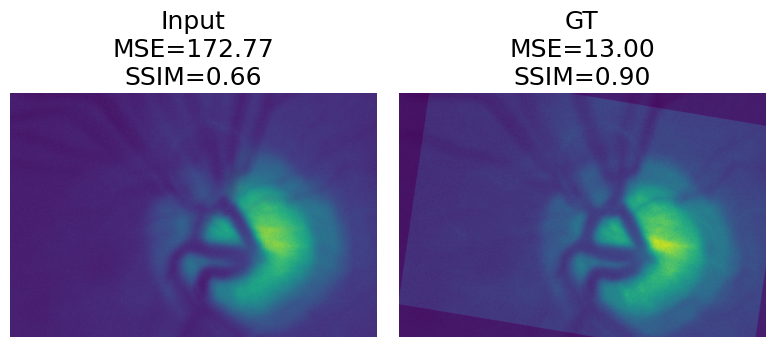

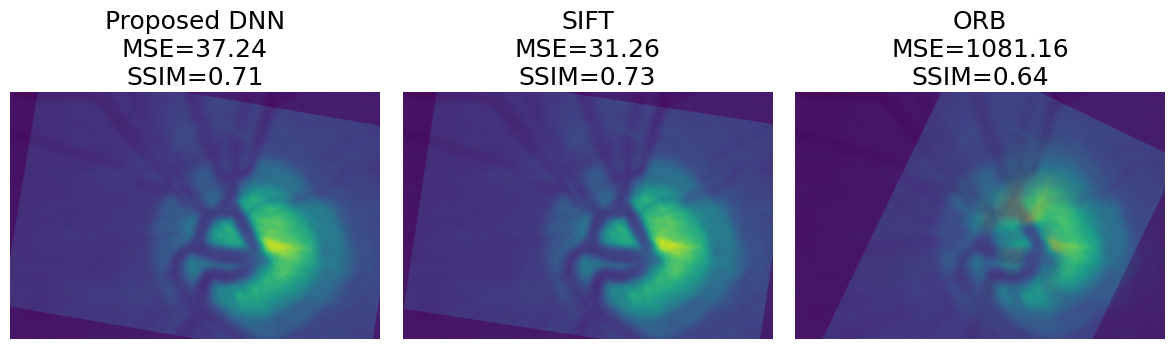

In [14]:
#img0, img1, params0 = next(loader)

out = model(img0, img1)

params = params0.detach().cpu().numpy().reshape(-1).tolist()
outputs = out.detach().cpu().numpy().reshape(-1).tolist()

frame0 = img0.detach().cpu().numpy()[0, 0, :, :]
frame0 = (frame0 * 255).astype('uint8')
frame1 = img1.detach().cpu().numpy()[0, 0, :, :]
frame1 = (frame1 * 255).astype('uint8')


input_mse = mean_squared_error(frame0, frame1)
input_ssim = structural_similarity(frame0, frame1)
gt_im, gt_mse, gt_ssim = warp_from_params_and_eval(frame0, frame1, params)
net_im, net_mse, net_ssim = warp_from_params_and_eval(frame0, frame1, outputs)
orb_im, orb_mse, orb_ssim = warp_and_eval(frame0, frame1, method="orb")
sift_im, sift_mse, sift_ssim = warp_and_eval(frame0, frame1, method="sift")

plt.figure(figsize = (8,4))
plt.rc('font', size=15)

plt.subplot(121)
plt.axis('off')
plt.title(f'Input\nMSE={input_mse:.2f}\nSSIM={input_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(frame1, alpha=0.4)

plt.subplot(122)
plt.axis('off')
plt.title(f'GT\nMSE={gt_mse:.2f}\nSSIM={gt_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(gt_im, alpha=0.4)

plt.tight_layout()
plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "eval2-comp4.1.png"))
plt.show()

plt.figure(figsize = (12,4))
plt.rc('font', size=15)

plt.subplot(131)
plt.axis('off')
plt.title(f'Proposed DNN\nMSE={net_mse:.2f}\nSSIM={net_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(net_im, alpha=0.4)

plt.subplot(132)
plt.axis('off')
plt.title(f'SIFT\nMSE={sift_mse:.2f}\nSSIM={sift_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(sift_im, alpha=0.4)

plt.subplot(133)
plt.axis('off')
plt.title(f'ORB\nMSE={orb_mse:.2f}\nSSIM={orb_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(orb_im, alpha=0.4)

plt.tight_layout()
plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "eval2-comp4.2.png"))
plt.show()


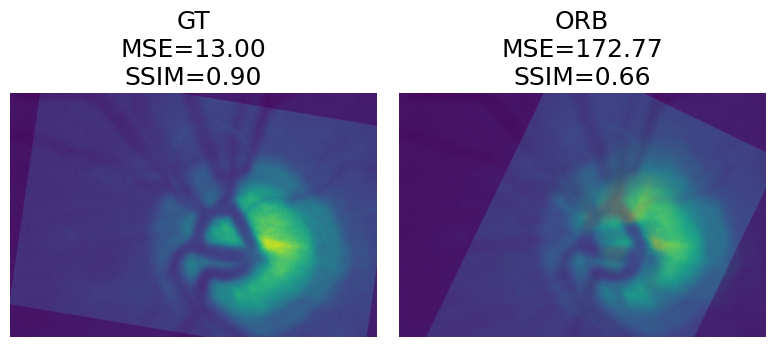

In [13]:
#img0, img1, params0 = next(loader)

out = model(img0, img1)

params = params0.detach().cpu().numpy().reshape(-1).tolist()
outputs = out.detach().cpu().numpy().reshape(-1).tolist()

frame0 = img0.detach().cpu().numpy()[0, 0, :, :]
frame0 = (frame0 * 255).astype('uint8')
frame1 = img1.detach().cpu().numpy()[0, 0, :, :]
frame1 = (frame1 * 255).astype('uint8')


input_mse = mean_squared_error(frame0, frame1)
input_ssim = structural_similarity(frame0, frame1)
gt_im, gt_mse, gt_ssim = warp_from_params_and_eval(frame0, frame1, params)
net_im, net_mse, net_ssim = warp_from_params_and_eval(frame0, frame1, outputs)
orb_im, orb_mse, orb_ssim = warp_and_eval(frame0, frame1, method="orb")
sift_im, sift_mse, sift_ssim = warp_and_eval(frame0, frame1, method="sift")

plt.figure(figsize = (8,4))
plt.rc('font', size=15)


plt.subplot(121)
plt.axis('off')
plt.title(f'GT\nMSE={gt_mse:.2f}\nSSIM={gt_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(gt_im, alpha=0.4)

plt.subplot(122)
plt.axis('off')
plt.title(f'ORB\nMSE={input_mse:.2f}\nSSIM={input_ssim:.2f}')
plt.imshow(frame0)
plt.imshow(orb_im, alpha=0.4)

plt.tight_layout()
plt.savefig(os.path.join("/content/drive/MyDrive/outputs/plots", "eval2-comp-wrong1.png"))
plt.show()


In [ ]:
ssim(frame0, gt_im)

0.8947926900329329